### Assignment Proj-02

> To use [QuickDraw dataset](https://quickdraw.withgoogle.com) with a larger dataset to do image classification with CNN

Below is the implementation with Keras using TF 

In [1]:
import numpy as np
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.utils import to_categorical, multi_gpu_model
from keras.callbacks import LearningRateScheduler
import keras.backend as K
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,Input, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.
/mnt/disks/workspace/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
print(keras.__version__) # updated directly from github (23/10/2017)
print(tf.__version__)

2.0.8
1.4.0-rc0


we use **100 classes** and **10K dataset**

In [3]:
classes = ['airplane','alarm clock','ambulance','angel','ant','anvil','apple','axe',
           'banana','bandage','barn','baseball bat','baseball','basket','basketball',
           'bathtub','beach','bear','beard','bed','bee','belt','bicycle','binoculars',
           'birthday cake','blueberry','book','boomerang','bottlecap','bowtie','bracelet',
           'brain','bread','broom','bulldozer','bus','bus','butterfly','cactus','cake',
           'calculator','calendar','camel','camera','campfire','candle','cannon','canoe',
           'car','carrot','cello','computer','cat','chandelier','clock','cloud','coffee cup',
           'compass','cookie','couch','cow','crab','crayon','crocodile','crown','cup',
           'diamond','dog','dolphin','donut','dragon','dresser','drill','drums','duck',
           'dumbbell','ear','elbow','elephant','envelope','eraser','eye','eyeglasses',
           'face','fan','feather','fence','finger','fire hydrant','fireplace','firetruck',
           'fish','flamingo','flashlight','flip flops','floor lamp','flower','flying saucer',
           'foot','fork']
num_classes = len(classes)

In [4]:
num_examples_per_class = 10000 # 10k dataset

In [5]:
x_data = np.load('data/x_data_100_classes_10k.npy')

In [6]:
labels = [np.full((num_examples_per_class,), classes.index(qdraw)) for qdraw in classes]

y_data = np.concatenate(labels,axis=0)

In [7]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

we shuffle the train and validation data 

In [8]:
x_data, y_data = unison_shuffled_copies(x_data, y_data)

In [9]:
img_rows = 28
img_cols = 28

total_size = x_data.shape[0]

num_pred = int(0.1 * total_size)              # set 10 % for testing 
num_validate = int(0.3 * total_size)          # set 30 % for validation
num_train = int(0.6 * total_size)             # set 60 % for training

x_train = x_data[0:num_train]
y_train = y_data[0:num_train]

x_test = x_data[num_train:(num_train+num_validate)]
y_test = y_data[num_train:(num_train+num_validate)]

x_pred = x_data[(num_train+num_validate):]
y_pred = y_data[(num_train+num_validate):]

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_pred = x_pred.reshape(x_pred.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

In [10]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_pred = x_pred.astype('float32')

# normalize the image to 0 to 1
x_train /= 255   
x_test /= 255
x_pred /= 255

print(x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_pred.shape[0], 'pred samples')

(600000, 28, 28, 1)
600000 train samples
300000 test samples
100000 pred samples


Hot encoding for the labels

In [11]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [12]:
Inp = Input(input_shape) # 8000, 28, 28, 1
x = Conv2D(32, kernel_size=(3, 3), activation='relu', name='Conv_01')(Inp)
x = Conv2D(64, (3, 3), activation='relu', name='Conv_02')(x)
x = MaxPooling2D(pool_size=(2, 2), name = 'MaxPool_01')(x)
x = Dropout(0.25, name='Dropout_01')(x)
x = Flatten(name='Flatten_01')(x)
x = Dense(128, activation='relu', name='Dense_01')(x)
x = BatchNormalization()(x)
x = Dropout(0.25, name = 'Dropout_02')(x)
output = Dense(num_classes, activation='softmax', name='Dense_02')(x)
model = Model(Inp, output)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_01 (Conv2D)             (None, 26, 26, 32)        320       
_________________________________________________________________
Conv_02 (Conv2D)             (None, 24, 24, 64)        18496     
_________________________________________________________________
MaxPool_01 (MaxPooling2D)    (None, 12, 12, 64)        0         
_________________________________________________________________
Dropout_01 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
Flatten_01 (Flatten)         (None, 9216)              0         
_________________________________________________________________
Dense_01 (Dense)             (None, 128)               1179776   
__________

In [15]:
train_epochs = 150
batch_sizes = 8192 * 2

In [16]:
def step_decay(epoch):
    if epoch<25:
        return 0.007    
    if epoch<50:
        return 0.005
    if epoch<75:
        return 0.002   
    return 0.001

lrate=LearningRateScheduler(step_decay)

In [17]:
adam = keras.optimizers.Adam()

In [18]:
parallel_model = multi_gpu_model(model, gpus=2)
parallel_model.compile( loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'] )

In [19]:
H = {} # history dict

#### Ready to train..

In [20]:
try:
    history = parallel_model.fit(x_train, y_train, 
                        batch_size = batch_sizes, 
                        epochs = train_epochs, verbose = 1, 
                        validation_data=(x_test, y_test), 
                        callbacks=[lrate])
    H = history.history
except KeyboardInterrupt:
    H = parallel_model.history.history
    print(' .. >> stopping.')
    pass

Train on 600000 samples, validate on 300000 samples
Epoch 1/150

600000/600000 [==============================] - ETA: 0s - loss: 2.5497 - acc: 0.4141 - val_loss: 2.7286 - val_acc: 0.3587
Epoch 2/150

600000/600000 [==============================] - ETA: 0s - loss: 1.6062 - acc: 0.6089 - val_loss: 1.7770 - val_acc: 0.6562
Epoch 3/150

294912/600000 [=============>................] - ETA: 19s - loss: 1.4403 - acc: 0.6461


600000/600000 [==============================] - ETA: 0s - loss: 1.4173 - acc: 0.6516 - val_loss: 1.4626 - val_acc: 0.6943
Epoch 4/150

600000/600000 [==============================] - ETA: 0s - loss: 1.3192 - acc: 0.6735 - val_loss: 1.2874 - val_acc: 0.7078
Epoch 5/150

600000/600000 [==============================] - ETA: 0s - loss: 1.2586 - acc: 0.6866 - val_loss: 1.1360 - val_acc: 0.7255


Epoch 6/150

600000/600000 [==============================] - ETA: 0s - loss: 1.2133 - acc: 0.6965 - val_loss: 1.0828 - val_acc: 0.7330
Epoch 7/150

600000/600000 [==============================] - ETA: 0s - loss: 1.1840 - acc: 0.7030 - val_loss: 1.0438 - val_acc: 0.7405
Epoch 8/150

311296/600000 [==============>...............] - ETA: 17s - loss: 1.1490 - acc: 0.7105


600000/600000 [==============================] - ETA: 0s - loss: 1.1544 - acc: 0.7099 - val_loss: 1.0284 - val_acc: 0.7444
Epoch 9/150

600000/600000 [==============================] - ETA: 0s - loss: 1.1327 - acc: 0.7142 - val_loss: 1.0108 - val_acc: 0.7482
Epoch 10/150

600000/600000 [==============================] - ETA: 0s - loss: 1.1163 - acc: 0.7178 - val_loss: 1.0052 - val_acc: 0.7498
Epoch 11/150



600000/600000 [==============================] - ETA: 0s - loss: 1.1039 - acc: 0.7201 - val_loss: 0.9949 - val_acc: 0.7519
Epoch 12/150

600000/600000 [==============================] - ETA: 0s - loss: 1.0886 - acc: 0.7240 - val_loss: 0.9985 - val_acc: 0.7519
Epoch 13/150

311296/600000 [==============>...............] - ETA: 17s - loss: 1.0699 - acc: 0.7277


600000/600000 [==============================] - ETA: 0s - loss: 1.0761 - acc: 0.7262 - val_loss: 0.9864 - val_acc: 0.7544
Epoch 14/150

600000/600000 [==============================] - ETA: 0s - loss: 1.0659 - acc: 0.7283 - val_loss: 0.9829 - val_acc: 0.7559
Epoch 15/150

600000/600000 [==============================] - ETA: 0s - loss: 1.0583 - acc: 0.7298 - val_loss: 0.9817 - val_acc: 0.7557
Epoch 16/150



600000/600000 [==============================] - ETA: 0s - loss: 1.0531 - acc: 0.7307 - val_loss: 0.9935 - val_acc: 0.7541
Epoch 17/150

600000/600000 [==============================] - ETA: 0s - loss: 1.0464 - acc: 0.7322 - val_loss: 0.9812 - val_acc: 0.7559
Epoch 18/150

311296/600000 [==============>...............] - ETA: 18s - loss: 1.0243 - acc: 0.7372


600000/600000 [==============================] - ETA: 0s - loss: 1.0357 - acc: 0.7347 - val_loss: 0.9722 - val_acc: 0.7586
Epoch 19/150

600000/600000 [==============================] - ETA: 0s - loss: 1.0317 - acc: 0.7356 - val_loss: 0.9674 - val_acc: 0.7588
Epoch 20/150

600000/600000 [==============================] - ETA: 0s - loss: 1.0259 - acc: 0.7359 - val_loss: 0.9698 - val_acc: 0.7587
Epoch 21/150



600000/600000 [==============================] - ETA: 0s - loss: 1.0185 - acc: 0.7384 - val_loss: 0.9657 - val_acc: 0.7604
Epoch 22/150

600000/600000 [==============================] - ETA: 0s - loss: 1.0128 - acc: 0.7396 - val_loss: 0.9598 - val_acc: 0.7608
Epoch 23/150

311296/600000 [==============>...............] - ETA: 19s - loss: 1.0004 - acc: 0.7417


600000/600000 [==============================] - ETA: 0s - loss: 1.0088 - acc: 0.7401 - val_loss: 0.9561 - val_acc: 0.7616
Epoch 24/150

600000/600000 [==============================] - ETA: 0s - loss: 1.0018 - acc: 0.7418 - val_loss: 0.9503 - val_acc: 0.7634
Epoch 25/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9996 - acc: 0.7426 - val_loss: 0.9496 - val_acc: 0.7634
Epoch 26/150



600000/600000 [==============================] - ETA: 0s - loss: 0.9818 - acc: 0.7463 - val_loss: 0.9395 - val_acc: 0.7657
Epoch 27/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9766 - acc: 0.7481 - val_loss: 0.9395 - val_acc: 0.7654
Epoch 28/150

311296/600000 [==============>...............] - ETA: 18s - loss: 0.9643 - acc: 0.7506


600000/600000 [==============================] - ETA: 0s - loss: 0.9736 - acc: 0.7489 - val_loss: 0.9442 - val_acc: 0.7646
Epoch 29/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9731 - acc: 0.7485 - val_loss: 0.9429 - val_acc: 0.7652
Epoch 30/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9689 - acc: 0.7489 - val_loss: 0.9382 - val_acc: 0.7661
Epoch 31/150



600000/600000 [==============================] - ETA: 0s - loss: 0.9647 - acc: 0.7495 - val_loss: 0.9425 - val_acc: 0.7648
Epoch 32/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9644 - acc: 0.7498 - val_loss: 0.9365 - val_acc: 0.7670
Epoch 33/150

311296/600000 [==============>...............] - ETA: 18s - loss: 0.9491 - acc: 0.7528


600000/600000 [==============================] - ETA: 0s - loss: 0.9599 - acc: 0.7510 - val_loss: 0.9382 - val_acc: 0.7653
Epoch 34/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9573 - acc: 0.7517 - val_loss: 0.9342 - val_acc: 0.7670
Epoch 35/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9550 - acc: 0.7518 - val_loss: 0.9376 - val_acc: 0.7659
Epoch 36/150



600000/600000 [==============================] - ETA: 0s - loss: 0.9542 - acc: 0.7514 - val_loss: 0.9389 - val_acc: 0.7655
Epoch 37/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9523 - acc: 0.7525 - val_loss: 0.9384 - val_acc: 0.7669
Epoch 38/150

311296/600000 [==============>...............] - ETA: 19s - loss: 0.9421 - acc: 0.7549


600000/600000 [==============================] - ETA: 0s - loss: 0.9489 - acc: 0.7535 - val_loss: 0.9351 - val_acc: 0.7666
Epoch 39/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9476 - acc: 0.7530 - val_loss: 0.9358 - val_acc: 0.7670
Epoch 40/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9451 - acc: 0.7536 - val_loss: 0.9457 - val_acc: 0.7647
Epoch 41/150



600000/600000 [==============================] - ETA: 0s - loss: 0.9457 - acc: 0.7538 - val_loss: 0.9431 - val_acc: 0.7647
Epoch 42/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9437 - acc: 0.7536 - val_loss: 0.9345 - val_acc: 0.7674
Epoch 43/150

311296/600000 [==============>...............] - ETA: 17s - loss: 0.9362 - acc: 0.7561


600000/600000 [==============================] - ETA: 0s - loss: 0.9423 - acc: 0.7540 - val_loss: 0.9314 - val_acc: 0.7681
Epoch 44/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9387 - acc: 0.7548 - val_loss: 0.9335 - val_acc: 0.7665
Epoch 45/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9380 - acc: 0.7549 - val_loss: 0.9381 - val_acc: 0.7661
Epoch 46/150



600000/600000 [==============================] - ETA: 0s - loss: 0.9346 - acc: 0.7565 - val_loss: 0.9301 - val_acc: 0.7674
Epoch 47/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9334 - acc: 0.7560 - val_loss: 0.9350 - val_acc: 0.7671
Epoch 48/150

311296/600000 [==============>...............] - ETA: 17s - loss: 0.9263 - acc: 0.7579


600000/600000 [==============================] - ETA: 0s - loss: 0.9324 - acc: 0.7563 - val_loss: 0.9293 - val_acc: 0.7677
Epoch 49/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9322 - acc: 0.7560 - val_loss: 0.9308 - val_acc: 0.7676
Epoch 50/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9303 - acc: 0.7565 - val_loss: 0.9322 - val_acc: 0.7676
Epoch 51/150



600000/600000 [==============================] - ETA: 0s - loss: 0.9158 - acc: 0.7605 - val_loss: 0.9202 - val_acc: 0.7700
Epoch 52/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9086 - acc: 0.7625 - val_loss: 0.9197 - val_acc: 0.7702
Epoch 53/150

311296/600000 [==============>...............] - ETA: 17s - loss: 0.9043 - acc: 0.7633


600000/600000 [==============================] - ETA: 0s - loss: 0.9060 - acc: 0.7626 - val_loss: 0.9197 - val_acc: 0.7702
Epoch 54/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9049 - acc: 0.7623 - val_loss: 0.9197 - val_acc: 0.7700
Epoch 55/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9033 - acc: 0.7626 - val_loss: 0.9208 - val_acc: 0.7697
Epoch 56/150



600000/600000 [==============================] - ETA: 0s - loss: 0.9028 - acc: 0.7625 - val_loss: 0.9196 - val_acc: 0.7707
Epoch 57/150

600000/600000 [==============================] - ETA: 0s - loss: 0.9015 - acc: 0.7637 - val_loss: 0.9196 - val_acc: 0.7703
Epoch 58/150

311296/600000 [==============>...............] - ETA: 19s - loss: 0.8964 - acc: 0.7647


600000/600000 [==============================] - ETA: 0s - loss: 0.9001 - acc: 0.7636 - val_loss: 0.9205 - val_acc: 0.7703
Epoch 59/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8998 - acc: 0.7632 - val_loss: 0.9212 - val_acc: 0.7703
Epoch 60/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8984 - acc: 0.7642 - val_loss: 0.9203 - val_acc: 0.7702
Epoch 61/150



600000/600000 [==============================] - ETA: 0s - loss: 0.8985 - acc: 0.7640 - val_loss: 0.9209 - val_acc: 0.7700
Epoch 62/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8966 - acc: 0.7642 - val_loss: 0.9196 - val_acc: 0.7704
Epoch 63/150

311296/600000 [==============>...............] - ETA: 18s - loss: 0.8920 - acc: 0.7648


600000/600000 [==============================] - ETA: 0s - loss: 0.8965 - acc: 0.7639 - val_loss: 0.9188 - val_acc: 0.7704
Epoch 64/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8956 - acc: 0.7644 - val_loss: 0.9199 - val_acc: 0.7702
Epoch 65/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8954 - acc: 0.7641 - val_loss: 0.9217 - val_acc: 0.7703
Epoch 66/150



600000/600000 [==============================] - ETA: 0s - loss: 0.8954 - acc: 0.7643 - val_loss: 0.9213 - val_acc: 0.7703
Epoch 67/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8937 - acc: 0.7646 - val_loss: 0.9201 - val_acc: 0.7707
Epoch 68/150

311296/600000 [==============>...............] - ETA: 17s - loss: 0.8875 - acc: 0.7667


600000/600000 [==============================] - ETA: 0s - loss: 0.8931 - acc: 0.7652 - val_loss: 0.9221 - val_acc: 0.7703
Epoch 69/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8931 - acc: 0.7646 - val_loss: 0.9209 - val_acc: 0.7707
Epoch 70/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8920 - acc: 0.7645 - val_loss: 0.9201 - val_acc: 0.7707
Epoch 71/150



600000/600000 [==============================] - ETA: 0s - loss: 0.8896 - acc: 0.7656 - val_loss: 0.9194 - val_acc: 0.7708
Epoch 72/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8902 - acc: 0.7657 - val_loss: 0.9206 - val_acc: 0.7704
Epoch 73/150

311296/600000 [==============>...............] - ETA: 18s - loss: 0.8869 - acc: 0.7656


600000/600000 [==============================] - ETA: 0s - loss: 0.8922 - acc: 0.7646 - val_loss: 0.9238 - val_acc: 0.7700
Epoch 74/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8889 - acc: 0.7651 - val_loss: 0.9198 - val_acc: 0.7706
Epoch 75/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8876 - acc: 0.7667 - val_loss: 0.9212 - val_acc: 0.7701
Epoch 76/150



600000/600000 [==============================] - ETA: 0s - loss: 0.8818 - acc: 0.7671 - val_loss: 0.9178 - val_acc: 0.7711
Epoch 77/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8801 - acc: 0.7680 - val_loss: 0.9181 - val_acc: 0.7711
Epoch 78/150

311296/600000 [==============>...............] - ETA: 17s - loss: 0.8810 - acc: 0.7685


600000/600000 [==============================] - ETA: 0s - loss: 0.8789 - acc: 0.7684 - val_loss: 0.9162 - val_acc: 0.7713
Epoch 79/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8787 - acc: 0.7679 - val_loss: 0.9167 - val_acc: 0.7714
Epoch 80/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8788 - acc: 0.7676 - val_loss: 0.9181 - val_acc: 0.7712
Epoch 81/150



600000/600000 [==============================] - ETA: 0s - loss: 0.8764 - acc: 0.7678 - val_loss: 0.9156 - val_acc: 0.7718
Epoch 82/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8772 - acc: 0.7681 - val_loss: 0.9165 - val_acc: 0.7716
Epoch 83/150

311296/600000 [==============>...............] - ETA: 18s - loss: 0.8717 - acc: 0.7683


600000/600000 [==============================] - ETA: 0s - loss: 0.8758 - acc: 0.7679 - val_loss: 0.9164 - val_acc: 0.7714
Epoch 84/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8765 - acc: 0.7686 - val_loss: 0.9161 - val_acc: 0.7713
Epoch 85/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8751 - acc: 0.7683 - val_loss: 0.9161 - val_acc: 0.7719
Epoch 86/150



600000/600000 [==============================] - ETA: 0s - loss: 0.8739 - acc: 0.7685 - val_loss: 0.9165 - val_acc: 0.7720
Epoch 87/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8740 - acc: 0.7686 - val_loss: 0.9157 - val_acc: 0.7717
Epoch 88/150

311296/600000 [==============>...............] - ETA: 18s - loss: 0.8711 - acc: 0.7695


600000/600000 [==============================] - ETA: 0s - loss: 0.8729 - acc: 0.7689 - val_loss: 0.9170 - val_acc: 0.7715
Epoch 89/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8734 - acc: 0.7690 - val_loss: 0.9168 - val_acc: 0.7717
Epoch 90/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8733 - acc: 0.7686 - val_loss: 0.9177 - val_acc: 0.7715
Epoch 91/150



600000/600000 [==============================] - ETA: 0s - loss: 0.8729 - acc: 0.7689 - val_loss: 0.9178 - val_acc: 0.7712
Epoch 92/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8723 - acc: 0.7692 - val_loss: 0.9170 - val_acc: 0.7717
Epoch 93/150

311296/600000 [==============>...............] - ETA: 18s - loss: 0.8685 - acc: 0.7696


600000/600000 [==============================] - ETA: 0s - loss: 0.8727 - acc: 0.7690 - val_loss: 0.9177 - val_acc: 0.7718
Epoch 94/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8724 - acc: 0.7691 - val_loss: 0.9169 - val_acc: 0.7719
Epoch 95/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8723 - acc: 0.7688 - val_loss: 0.9172 - val_acc: 0.7720
Epoch 96/150



600000/600000 [==============================] - ETA: 0s - loss: 0.8724 - acc: 0.7687 - val_loss: 0.9165 - val_acc: 0.7717
Epoch 97/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8698 - acc: 0.7695 - val_loss: 0.9170 - val_acc: 0.7718
Epoch 98/150

311296/600000 [==============>...............] - ETA: 18s - loss: 0.8709 - acc: 0.7690


600000/600000 [==============================] - ETA: 0s - loss: 0.8707 - acc: 0.7693 - val_loss: 0.9169 - val_acc: 0.7717
Epoch 99/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8706 - acc: 0.7693 - val_loss: 0.9187 - val_acc: 0.7715
Epoch 100/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8692 - acc: 0.7694 - val_loss: 0.9178 - val_acc: 0.7719
Epoch 101/150



600000/600000 [==============================] - ETA: 0s - loss: 0.8691 - acc: 0.7699 - val_loss: 0.9171 - val_acc: 0.7718
Epoch 102/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8673 - acc: 0.7699 - val_loss: 0.9175 - val_acc: 0.7721
Epoch 103/150

311296/600000 [==============>...............] - ETA: 19s - loss: 0.8696 - acc: 0.7693


600000/600000 [==============================] - ETA: 0s - loss: 0.8697 - acc: 0.7689 - val_loss: 0.9181 - val_acc: 0.7717
Epoch 104/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8680 - acc: 0.7700 - val_loss: 0.9176 - val_acc: 0.7714
Epoch 105/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8677 - acc: 0.7696 - val_loss: 0.9168 - val_acc: 0.7721
Epoch 106/150



600000/600000 [==============================] - ETA: 0s - loss: 0.8682 - acc: 0.7699 - val_loss: 0.9171 - val_acc: 0.7718
Epoch 107/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8680 - acc: 0.7696 - val_loss: 0.9161 - val_acc: 0.7720
Epoch 108/150

311296/600000 [==============>...............] - ETA: 18s - loss: 0.8676 - acc: 0.7701


600000/600000 [==============================] - ETA: 0s - loss: 0.8685 - acc: 0.7694 - val_loss: 0.9188 - val_acc: 0.7717
Epoch 109/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8654 - acc: 0.7705 - val_loss: 0.9172 - val_acc: 0.7717
Epoch 110/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8674 - acc: 0.7701 - val_loss: 0.9173 - val_acc: 0.7718
Epoch 111/150



600000/600000 [==============================] - ETA: 0s - loss: 0.8656 - acc: 0.7705 - val_loss: 0.9172 - val_acc: 0.7716
Epoch 112/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8651 - acc: 0.7700 - val_loss: 0.9183 - val_acc: 0.7716
Epoch 113/150

311296/600000 [==============>...............] - ETA: 19s - loss: 0.8602 - acc: 0.7715


600000/600000 [==============================] - ETA: 0s - loss: 0.8657 - acc: 0.7705 - val_loss: 0.9166 - val_acc: 0.7718
Epoch 114/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8665 - acc: 0.7699 - val_loss: 0.9196 - val_acc: 0.7712
Epoch 115/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8645 - acc: 0.7708 - val_loss: 0.9175 - val_acc: 0.7718
Epoch 116/150



600000/600000 [==============================] - ETA: 0s - loss: 0.8654 - acc: 0.7697 - val_loss: 0.9192 - val_acc: 0.7714
Epoch 117/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8654 - acc: 0.7697 - val_loss: 0.9176 - val_acc: 0.7718
Epoch 118/150

311296/600000 [==============>...............] - ETA: 17s - loss: 0.8641 - acc: 0.7701


600000/600000 [==============================] - ETA: 0s - loss: 0.8654 - acc: 0.7699 - val_loss: 0.9180 - val_acc: 0.7716
Epoch 119/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8616 - acc: 0.7714 - val_loss: 0.9197 - val_acc: 0.7709
Epoch 120/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8641 - acc: 0.7705 - val_loss: 0.9186 - val_acc: 0.7718
Epoch 121/150



600000/600000 [==============================] - ETA: 0s - loss: 0.8625 - acc: 0.7711 - val_loss: 0.9178 - val_acc: 0.7714
Epoch 122/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8633 - acc: 0.7710 - val_loss: 0.9195 - val_acc: 0.7708
Epoch 123/150

311296/600000 [==============>...............] - ETA: 19s - loss: 0.8602 - acc: 0.7712


600000/600000 [==============================] - ETA: 0s - loss: 0.8628 - acc: 0.7706 - val_loss: 0.9188 - val_acc: 0.7714
Epoch 124/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8629 - acc: 0.7706 - val_loss: 0.9178 - val_acc: 0.7718
Epoch 125/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8630 - acc: 0.7704 - val_loss: 0.9185 - val_acc: 0.7711
Epoch 126/150



600000/600000 [==============================] - ETA: 0s - loss: 0.8611 - acc: 0.7711 - val_loss: 0.9187 - val_acc: 0.7713
Epoch 127/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8610 - acc: 0.7713 - val_loss: 0.9187 - val_acc: 0.7718
Epoch 128/150

311296/600000 [==============>...............] - ETA: 18s - loss: 0.8598 - acc: 0.7712


600000/600000 [==============================] - ETA: 0s - loss: 0.8613 - acc: 0.7709 - val_loss: 0.9183 - val_acc: 0.7716
Epoch 129/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8614 - acc: 0.7709 - val_loss: 0.9196 - val_acc: 0.7712
Epoch 130/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8613 - acc: 0.7709 - val_loss: 0.9185 - val_acc: 0.7719
Epoch 131/150



600000/600000 [==============================] - ETA: 0s - loss: 0.8617 - acc: 0.7707 - val_loss: 0.9179 - val_acc: 0.7716
Epoch 132/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8604 - acc: 0.7715 - val_loss: 0.9183 - val_acc: 0.7713
Epoch 133/150

311296/600000 [==============>...............] - ETA: 18s - loss: 0.8556 - acc: 0.7721


600000/600000 [==============================] - ETA: 0s - loss: 0.8586 - acc: 0.7715 - val_loss: 0.9193 - val_acc: 0.7716
Epoch 134/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8588 - acc: 0.7715 - val_loss: 0.9183 - val_acc: 0.7715
Epoch 135/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8588 - acc: 0.7713 - val_loss: 0.9177 - val_acc: 0.7717
Epoch 136/150



600000/600000 [==============================] - ETA: 0s - loss: 0.8588 - acc: 0.7719 - val_loss: 0.9182 - val_acc: 0.7716
Epoch 137/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8576 - acc: 0.7716 - val_loss: 0.9179 - val_acc: 0.7715
Epoch 138/150

311296/600000 [==============>...............] - ETA: 18s - loss: 0.8540 - acc: 0.7730


600000/600000 [==============================] - ETA: 0s - loss: 0.8571 - acc: 0.7722 - val_loss: 0.9187 - val_acc: 0.7715
Epoch 139/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8591 - acc: 0.7710 - val_loss: 0.9183 - val_acc: 0.7715
Epoch 140/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8589 - acc: 0.7713 - val_loss: 0.9191 - val_acc: 0.7717
Epoch 141/150



600000/600000 [==============================] - ETA: 0s - loss: 0.8580 - acc: 0.7714 - val_loss: 0.9195 - val_acc: 0.7713
Epoch 142/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8580 - acc: 0.7716 - val_loss: 0.9191 - val_acc: 0.7712
Epoch 143/150

311296/600000 [==============>...............] - ETA: 18s - loss: 0.8544 - acc: 0.7721


600000/600000 [==============================] - ETA: 0s - loss: 0.8589 - acc: 0.7709 - val_loss: 0.9183 - val_acc: 0.7713
Epoch 144/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8564 - acc: 0.7719 - val_loss: 0.9183 - val_acc: 0.7709
Epoch 145/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8564 - acc: 0.7713 - val_loss: 0.9172 - val_acc: 0.7716
Epoch 146/150



600000/600000 [==============================] - ETA: 0s - loss: 0.8574 - acc: 0.7717 - val_loss: 0.9199 - val_acc: 0.7716
Epoch 147/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8563 - acc: 0.7716 - val_loss: 0.9183 - val_acc: 0.7716
Epoch 148/150

311296/600000 [==============>...............] - ETA: 18s - loss: 0.8542 - acc: 0.7731


600000/600000 [==============================] - ETA: 0s - loss: 0.8565 - acc: 0.7723 - val_loss: 0.9186 - val_acc: 0.7715
Epoch 149/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8554 - acc: 0.7719 - val_loss: 0.9187 - val_acc: 0.7711
Epoch 150/150

600000/600000 [==============================] - ETA: 0s - loss: 0.8533 - acc: 0.7729 - val_loss: 0.9197 - val_acc: 0.7710


In [21]:
# model.save('modelqd.h5')
# parallel_model.save('modelqd.h5')
parallel_model.save_weights('weightsqd.h5')

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_train(hist):
    h = hist
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist[meas])
    plt.plot(hist['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

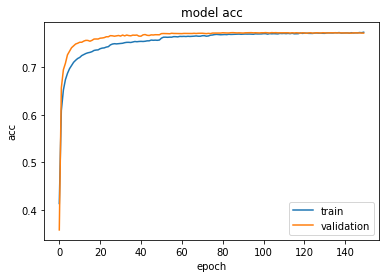

In [23]:
# plot_train(H)
# dir(parallel_model)
plot_train(parallel_model.history.history)

In [24]:
evaluation = parallel_model.evaluate(x_test, y_test,
          batch_size=batch_sizes)
print('.')
print('Model Accuracy = %.2f' % (evaluation[1]))
print('Model Loss = %.2f' % (evaluation[0]))


300000/300000 [==============================] - ETA: 0s
.
Model Accuracy = 0.77
Model Loss = 0.92


#### Let's make predictions

In [25]:
res = model.predict(x_pred)

n_count = 0
i = 0
le = []
for r in res:
    idx = np.argmax(r)
    if idx != y_pred[i]:
        n_count = n_count + 1
        # w = r.argsort()[-3:][::-1]
        # print( classes[y_pred[i]], [classes[y_pred[j]] for j in w] )
    i = i + 1

print('Total error:', n_count, 'out of', x_pred.shape[0], 'or',n_count/x_pred.shape[0]*100,'%')

Total error: 22639 out of 100000 or 22.639 %


In [26]:
pred_accuracy = (x_pred.shape[0]-n_count) / x_pred.shape[0] * 100
print('Prediction accuracy: %.2f' % pred_accuracy + '% out of', x_pred.shape[0], 'dataset')

Prediction accuracy: 77.36% out of 100000 dataset


The prediction accuracy is **77.36 %** out of 100000 dataset

In [29]:
def show_qdraw(img):
    image = img.reshape([28,28])
    fig, axes = plt.subplots(1, )
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.imshow(image, cmap='gray_r')
    plt.show()

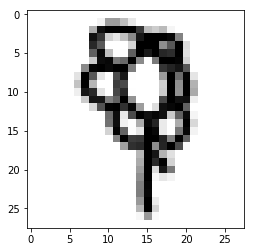

flower


In [41]:
tidx = 300
show_qdraw(x_pred[tidx])
print(classes[y_pred[tidx]])

In [43]:
idx = np.argmax(res[tidx])
print('what our network predicts',classes[idx])

what our network predicts flower


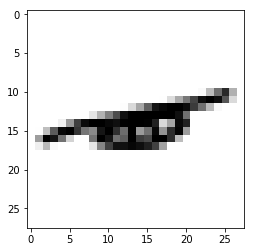

bandage
what our network predicts belt


In [44]:
i = 0
for r in res:
    idx = np.argmax(r)
    if idx != y_pred[i]:
        break
    i = i + 1

tidx = i
show_qdraw(x_pred[i])
print(classes[y_pred[i]])
idx = np.argmax(res[tidx])
print('what our network predicts',classes[idx])